In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap.umap_ as umap
from models import JointLatentDiffusionNoisyClassifier
from models import get_model_class

from datasets import AdjustedSVHN, AdjustedMNIST, AdjustedFashionMNIST
import torchvision as tv
from ldm.util import default
from datasets import get_dataloaders


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-04 08:45:22.149233: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 08:45:22.808866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 08:45:23.203203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appr

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
EXTRACTED_DATA_PATH = 'mediffusion_imagenet_extracted_data'


In [5]:
sd = torch.load("/home/jk/Joint-Diffusion-in-Latent-Space/models_best/epoch=000012.ckpt")["state_dict"]

In [6]:
sd['classifier.4.bias']
del sd

tensor([ 0.0244, -0.0162,  0.0069, -0.0252, -0.0286,  0.0234,  0.0071,  0.0045,
        -0.0257, -0.0126,  0.0255, -0.0023, -0.0177,  0.0206], device='cuda:0')

In [7]:
config = OmegaConf.load("/home/jk/Joint-Diffusion-in-Latent-Space/models_best/i00res2_c_p2.yaml")
#config.model.params["ckpt_path"] = f"logs/JointDiffusion_2023-04-24T22-09-09/checkpoints/last.ckpt"
#model = JointLatentDiffusionNoisyClassifier(**config.model.get("params", dict()))
model = get_model_class(config.model.get("model_type"))(**config.model.get("params", dict()))
model.learning_rate = config.model.base_learning_rate
try:
    model.classifier_lr = config.model.classifier_lr
    print(['CLASSIFIER HAS SEPARATE LR'])
except:
    model.classifier_lr=None
    print(['CLASSIFIER HAS THE SAME LR'])

model.sampling_method = "unconditional"
model.gradient_guided_sampling=False
model.to(device)

dl_config = config.pop("dataloaders")
train_dls, val_dl, test_dl = get_dataloaders(**dl_config)


LatentSSLPoolingMultilabel: Running in eps-prediction mode
DiffusionWrapper has 257.73 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/models_imagenet/imagenet_vae.ckpt with 0 missing and 49 unexpected keys
Training LatentSSLPoolingMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/models_best/epoch=000012.ckpt with 0 missing and 0 unexpected keys
[WARNING] AUROC HARDCODED for 14 classes
['CLASSIFIER HAS SEPARATE LR']


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
SSL DATSDET LOADING
[WARNING] Chest_xray_nih_sssl.py dataset - TO avoid errors we have val loader mocked with train data 2%!!!!
LENGTHS of train lab, train unlab, test 2077 86524 2077 25596


In [8]:
print(model.classifier.state_dict()['4.bias'])


tensor([ 0.0244, -0.0162,  0.0069, -0.0252, -0.0286,  0.0234,  0.0071,  0.0045,
        -0.0257, -0.0126,  0.0255, -0.0023, -0.0177,  0.0206], device='cuda:0')


In [9]:
train_lab, train_unlab = train_dls

In [10]:
batch = next(iter(train_unlab))

In [11]:
batch[1].shape

torch.Size([32, 15])

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.0, inplace=False)
  (1): Linear(in_features=5632, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=1024, out_features=14, bias=True)
)

In [13]:
import torch
import os
from tqdm import tqdm

@torch.no_grad()
def extract_representations(batch):
    x = batch[0]
    x = model.to_latent(x, arrange=False)
    y = batch[1]
    t = torch.randint(
        0, model.num_timesteps, (x.shape[0],), device=device
    ).long()
    noise = torch.randn_like(x)
    x_noisy = model.q_sample(x_start=x, t=t, noise=noise)

    unet = model.model.diffusion_model
    representations = unet.just_representations(x_noisy, t, pooled=False)
    representations = model.transform_representations(representations)
    return representations, y

def save_representations_and_targets(dataloader, save_path, file_prefix):
    os.makedirs(save_path, exist_ok=True)
    all_representations = []
    all_targets = []

    for batch in tqdm(dataloader, desc=f"Processing {file_prefix}"):
        representations, targets = extract_representations(batch)
        all_representations.append(representations.cpu())
        all_targets.append(targets.cpu())

    all_representations = torch.cat(all_representations)
    all_targets = torch.cat(all_targets)

    torch.save(all_representations, os.path.join(save_path, f"{file_prefix}_representations.pt"))
    torch.save(all_targets, os.path.join(save_path, f"{file_prefix}_targets.pt"))

#save_representations_and_targets(train_lab, EXTRACTED_DATA_PATH, 'train_lab')
#save_representations_and_targets(train_unlab, EXTRACTED_DATA_PATH, 'train_unlab')
#save_representations_and_targets(test_dl, EXTRACTED_DATA_PATH, 'test')


In [14]:
class RepresentationDataset(torch.utils.data.Dataset):
    def __init__(self, representations_path, targets_path):
        self.representations = torch.load(representations_path)
        self.targets = torch.load(targets_path)

    def __len__(self):
        return len(self.representations)

    def __getitem__(self, idx):
        return self.representations[idx], self.targets[idx][:-1].float()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for representations, targets in tqdm(train_loader, desc="Training"):
        representations, targets = representations.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(representations)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * representations.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate_model(model, val_loader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for representations, targets in tqdm(val_loader, desc="Evaluating"):
            representations, targets = representations.to(device), targets.to(device)
            outputs = model(representations)
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    auroc = roc_auc_score(all_targets, all_predictions, average='macro', multi_class='ovr')
    return auroc


In [16]:
# Assuming RepresentationDataset class is defined as in previous step

# Paths to the saved data
train_lab_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'train_lab_representations.pt')
train_lab_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'train_lab_targets.pt')
train_unlab_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'train_unlab_representations.pt')
train_unlab_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'train_unlab_targets.pt')
test_representations_path = os.path.join(EXTRACTED_DATA_PATH, 'test_representations.pt')
test_targets_path = os.path.join(EXTRACTED_DATA_PATH, 'test_targets.pt')

# Create datasets
train_lab_dataset = RepresentationDataset(train_lab_representations_path, train_lab_targets_path)
train_unlab_dataset = RepresentationDataset(train_unlab_representations_path, train_unlab_targets_path)
test_dataset = RepresentationDataset(test_representations_path, test_targets_path)

# Create data loaders
train_loader = DataLoader(train_lab_dataset, batch_size=64, shuffle=True)
train_unl_loader = DataLoader(train_unlab_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# Assuming model.classifier is defined as provided
#classifier = model.classifier.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.eval()
# Evaluate on test dataset
test_auroc = evaluate_model(model.classifier, test_loader, device)
print(f"Test AUROC: {test_auroc:.4f}")
model.train()
# Train and evaluate the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_model(model.classifier, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Evaluate on test dataset
    if epoch%10==0:
        test_auroc = evaluate_model(model.classifier, test_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Test AUROC: {test_auroc:.4f}")


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 593.30it/s]


Test AUROC: 0.5202


Training: 100%|██████████| 32/32 [00:00<00:00, 119.66it/s]


Epoch 1/100, Training Loss: 1.0786


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 635.24it/s]


Epoch 1/100, Test AUROC: 0.5043


Training: 100%|██████████| 32/32 [00:00<00:00, 269.04it/s]


Epoch 2/100, Training Loss: 0.3814


Training: 100%|██████████| 32/32 [00:00<00:00, 238.08it/s]


Epoch 3/100, Training Loss: 0.2556


Training: 100%|██████████| 32/32 [00:00<00:00, 239.10it/s]


Epoch 4/100, Training Loss: 0.2355


Training: 100%|██████████| 32/32 [00:00<00:00, 299.15it/s]


Epoch 5/100, Training Loss: 0.2506


Training: 100%|██████████| 32/32 [00:00<00:00, 302.47it/s]


Epoch 6/100, Training Loss: 0.2435


Training: 100%|██████████| 32/32 [00:00<00:00, 298.59it/s]


Epoch 7/100, Training Loss: 0.2376


Training: 100%|██████████| 32/32 [00:00<00:00, 303.97it/s]


Epoch 8/100, Training Loss: 0.2313


Training: 100%|██████████| 32/32 [00:00<00:00, 304.03it/s]


Epoch 9/100, Training Loss: 0.2313


Training: 100%|██████████| 32/32 [00:00<00:00, 302.74it/s]


Epoch 10/100, Training Loss: 0.2270


Training: 100%|██████████| 32/32 [00:00<00:00, 305.26it/s]


Epoch 11/100, Training Loss: 0.2219


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 634.89it/s]


Epoch 11/100, Test AUROC: 0.5473


Training: 100%|██████████| 32/32 [00:00<00:00, 299.25it/s]


Epoch 12/100, Training Loss: 0.2160


Training: 100%|██████████| 32/32 [00:00<00:00, 305.72it/s]


Epoch 13/100, Training Loss: 0.2129


Training: 100%|██████████| 32/32 [00:00<00:00, 300.99it/s]


Epoch 14/100, Training Loss: 0.2163


Training: 100%|██████████| 32/32 [00:00<00:00, 306.24it/s]


Epoch 15/100, Training Loss: 0.2137


Training: 100%|██████████| 32/32 [00:00<00:00, 300.72it/s]


Epoch 16/100, Training Loss: 0.2061


Training: 100%|██████████| 32/32 [00:00<00:00, 304.00it/s]


Epoch 17/100, Training Loss: 0.2064


Training: 100%|██████████| 32/32 [00:00<00:00, 303.11it/s]


Epoch 18/100, Training Loss: 0.2158


Training: 100%|██████████| 32/32 [00:00<00:00, 304.32it/s]


Epoch 19/100, Training Loss: 0.2130


Training: 100%|██████████| 32/32 [00:00<00:00, 300.68it/s]


Epoch 20/100, Training Loss: 0.2066


Training: 100%|██████████| 32/32 [00:00<00:00, 301.00it/s]


Epoch 21/100, Training Loss: 0.2070


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 630.00it/s]


Epoch 21/100, Test AUROC: 0.5471


Training: 100%|██████████| 32/32 [00:00<00:00, 301.21it/s]


Epoch 22/100, Training Loss: 0.1900


Training: 100%|██████████| 32/32 [00:00<00:00, 305.70it/s]


Epoch 23/100, Training Loss: 0.1945


Training: 100%|██████████| 32/32 [00:00<00:00, 302.32it/s]


Epoch 24/100, Training Loss: 0.1963


Training: 100%|██████████| 32/32 [00:00<00:00, 306.41it/s]


Epoch 25/100, Training Loss: 0.1921


Training: 100%|██████████| 32/32 [00:00<00:00, 303.87it/s]


Epoch 26/100, Training Loss: 0.2002


Training: 100%|██████████| 32/32 [00:00<00:00, 301.84it/s]


Epoch 27/100, Training Loss: 0.1896


Training: 100%|██████████| 32/32 [00:00<00:00, 301.25it/s]


Epoch 28/100, Training Loss: 0.2143


Training: 100%|██████████| 32/32 [00:00<00:00, 301.42it/s]


Epoch 29/100, Training Loss: 0.1880


Training: 100%|██████████| 32/32 [00:00<00:00, 304.33it/s]


Epoch 30/100, Training Loss: 0.2050


Training: 100%|██████████| 32/32 [00:00<00:00, 306.35it/s]


Epoch 31/100, Training Loss: 0.2191


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 628.46it/s]


Epoch 31/100, Test AUROC: 0.5482


Training: 100%|██████████| 32/32 [00:00<00:00, 297.14it/s]


Epoch 32/100, Training Loss: 0.2062


Training: 100%|██████████| 32/32 [00:00<00:00, 306.45it/s]


Epoch 33/100, Training Loss: 0.1834


Training: 100%|██████████| 32/32 [00:00<00:00, 301.39it/s]


Epoch 34/100, Training Loss: 0.1892


Training: 100%|██████████| 32/32 [00:00<00:00, 305.25it/s]


Epoch 35/100, Training Loss: 0.1911


Training: 100%|██████████| 32/32 [00:00<00:00, 300.32it/s]


Epoch 36/100, Training Loss: 0.2248


Training: 100%|██████████| 32/32 [00:00<00:00, 303.02it/s]


Epoch 37/100, Training Loss: 0.1850


Training: 100%|██████████| 32/32 [00:00<00:00, 299.37it/s]


Epoch 38/100, Training Loss: 0.1758


Training: 100%|██████████| 32/32 [00:00<00:00, 300.08it/s]


Epoch 39/100, Training Loss: 0.1736


Training: 100%|██████████| 32/32 [00:00<00:00, 297.21it/s]


Epoch 40/100, Training Loss: 0.1875


Training: 100%|██████████| 32/32 [00:00<00:00, 300.37it/s]


Epoch 41/100, Training Loss: 0.1726


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 633.85it/s]


Epoch 41/100, Test AUROC: 0.5574


Training: 100%|██████████| 32/32 [00:00<00:00, 299.13it/s]


Epoch 42/100, Training Loss: 0.1838


Training: 100%|██████████| 32/32 [00:00<00:00, 306.80it/s]


Epoch 43/100, Training Loss: 0.1578


Training: 100%|██████████| 32/32 [00:00<00:00, 302.47it/s]


Epoch 44/100, Training Loss: 0.1581


Training: 100%|██████████| 32/32 [00:00<00:00, 302.23it/s]


Epoch 45/100, Training Loss: 0.1845


Training: 100%|██████████| 32/32 [00:00<00:00, 302.89it/s]


Epoch 46/100, Training Loss: 0.1934


Training: 100%|██████████| 32/32 [00:00<00:00, 308.35it/s]


Epoch 47/100, Training Loss: 0.1678


Training: 100%|██████████| 32/32 [00:00<00:00, 302.82it/s]


Epoch 48/100, Training Loss: 0.1715


Training: 100%|██████████| 32/32 [00:00<00:00, 306.78it/s]


Epoch 49/100, Training Loss: 0.1920


Training: 100%|██████████| 32/32 [00:00<00:00, 300.88it/s]


Epoch 50/100, Training Loss: 0.1604


Training: 100%|██████████| 32/32 [00:00<00:00, 303.15it/s]


Epoch 51/100, Training Loss: 0.1613


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 633.32it/s]


Epoch 51/100, Test AUROC: 0.5505


Training: 100%|██████████| 32/32 [00:00<00:00, 297.77it/s]


Epoch 52/100, Training Loss: 0.1628


Training: 100%|██████████| 32/32 [00:00<00:00, 303.98it/s]


Epoch 53/100, Training Loss: 0.1511


Training: 100%|██████████| 32/32 [00:00<00:00, 306.39it/s]


Epoch 54/100, Training Loss: 0.1447


Training: 100%|██████████| 32/32 [00:00<00:00, 303.46it/s]


Epoch 55/100, Training Loss: 0.1660


Training: 100%|██████████| 32/32 [00:00<00:00, 303.00it/s]


Epoch 56/100, Training Loss: 0.1843


Training: 100%|██████████| 32/32 [00:00<00:00, 305.63it/s]


Epoch 57/100, Training Loss: 0.1416


Training: 100%|██████████| 32/32 [00:00<00:00, 303.81it/s]


Epoch 58/100, Training Loss: 0.1685


Training: 100%|██████████| 32/32 [00:00<00:00, 299.72it/s]


Epoch 59/100, Training Loss: 0.1446


Training: 100%|██████████| 32/32 [00:00<00:00, 305.78it/s]


Epoch 60/100, Training Loss: 0.1612


Training: 100%|██████████| 32/32 [00:00<00:00, 301.97it/s]


Epoch 61/100, Training Loss: 0.1412


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 634.76it/s]


Epoch 61/100, Test AUROC: 0.5390


Training: 100%|██████████| 32/32 [00:00<00:00, 303.09it/s]


Epoch 62/100, Training Loss: 0.1616


Training: 100%|██████████| 32/32 [00:00<00:00, 303.31it/s]


Epoch 63/100, Training Loss: 0.1573


Training: 100%|██████████| 32/32 [00:00<00:00, 296.40it/s]


Epoch 64/100, Training Loss: 0.1460


Training: 100%|██████████| 32/32 [00:00<00:00, 302.06it/s]


Epoch 65/100, Training Loss: 0.1647


Training: 100%|██████████| 32/32 [00:00<00:00, 299.47it/s]


Epoch 66/100, Training Loss: 0.1222


Training: 100%|██████████| 32/32 [00:00<00:00, 297.49it/s]


Epoch 67/100, Training Loss: 0.1488


Training: 100%|██████████| 32/32 [00:00<00:00, 299.18it/s]


Epoch 68/100, Training Loss: 0.1387


Training: 100%|██████████| 32/32 [00:00<00:00, 291.93it/s]


Epoch 69/100, Training Loss: 0.1196


Training: 100%|██████████| 32/32 [00:00<00:00, 295.11it/s]


Epoch 70/100, Training Loss: 0.1341


Training: 100%|██████████| 32/32 [00:00<00:00, 295.40it/s]


Epoch 71/100, Training Loss: 0.1473


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 622.57it/s]


Epoch 71/100, Test AUROC: 0.5447


Training: 100%|██████████| 32/32 [00:00<00:00, 298.15it/s]


Epoch 72/100, Training Loss: 0.1367


Training: 100%|██████████| 32/32 [00:00<00:00, 306.96it/s]


Epoch 73/100, Training Loss: 0.1118


Training: 100%|██████████| 32/32 [00:00<00:00, 303.01it/s]


Epoch 74/100, Training Loss: 0.1095


Training: 100%|██████████| 32/32 [00:00<00:00, 304.12it/s]


Epoch 75/100, Training Loss: 0.1324


Training: 100%|██████████| 32/32 [00:00<00:00, 303.42it/s]


Epoch 76/100, Training Loss: 0.1075


Training: 100%|██████████| 32/32 [00:00<00:00, 306.63it/s]


Epoch 77/100, Training Loss: 0.1150


Training: 100%|██████████| 32/32 [00:00<00:00, 302.60it/s]


Epoch 78/100, Training Loss: 0.1257


Training: 100%|██████████| 32/32 [00:00<00:00, 303.13it/s]


Epoch 79/100, Training Loss: 0.1320


Training: 100%|██████████| 32/32 [00:00<00:00, 275.65it/s]


Epoch 80/100, Training Loss: 0.1733


Training: 100%|██████████| 32/32 [00:00<00:00, 273.73it/s]


Epoch 81/100, Training Loss: 0.1892


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 629.04it/s]


Epoch 81/100, Test AUROC: 0.5416


Training: 100%|██████████| 32/32 [00:00<00:00, 309.54it/s]


Epoch 82/100, Training Loss: 0.1170


Training: 100%|██████████| 32/32 [00:00<00:00, 300.73it/s]


Epoch 83/100, Training Loss: 0.1338


Training: 100%|██████████| 32/32 [00:00<00:00, 301.18it/s]


Epoch 84/100, Training Loss: 0.1052


Training: 100%|██████████| 32/32 [00:00<00:00, 306.74it/s]


Epoch 85/100, Training Loss: 0.1218


Training: 100%|██████████| 32/32 [00:00<00:00, 302.67it/s]


Epoch 86/100, Training Loss: 0.0988


Training: 100%|██████████| 32/32 [00:00<00:00, 301.50it/s]


Epoch 87/100, Training Loss: 0.0967


Training: 100%|██████████| 32/32 [00:00<00:00, 300.53it/s]


Epoch 88/100, Training Loss: 0.1369


Training: 100%|██████████| 32/32 [00:00<00:00, 303.33it/s]


Epoch 89/100, Training Loss: 0.1599


Training: 100%|██████████| 32/32 [00:00<00:00, 301.02it/s]


Epoch 90/100, Training Loss: 0.1439


Training: 100%|██████████| 32/32 [00:00<00:00, 302.38it/s]


Epoch 91/100, Training Loss: 0.1195


Evaluating: 100%|██████████| 400/400 [00:00<00:00, 635.62it/s]


Epoch 91/100, Test AUROC: 0.5402


Training: 100%|██████████| 32/32 [00:00<00:00, 294.96it/s]


Epoch 92/100, Training Loss: 0.1074


Training: 100%|██████████| 32/32 [00:00<00:00, 295.19it/s]


Epoch 93/100, Training Loss: 0.1160


Training: 100%|██████████| 32/32 [00:00<00:00, 294.44it/s]


Epoch 94/100, Training Loss: 0.1051


Training: 100%|██████████| 32/32 [00:00<00:00, 296.71it/s]


Epoch 95/100, Training Loss: 0.0744


Training: 100%|██████████| 32/32 [00:00<00:00, 293.57it/s]


Epoch 96/100, Training Loss: 0.0672


Training: 100%|██████████| 32/32 [00:00<00:00, 299.95it/s]


Epoch 97/100, Training Loss: 0.0991


Training: 100%|██████████| 32/32 [00:00<00:00, 297.29it/s]


Epoch 98/100, Training Loss: 0.0680


Training: 100%|██████████| 32/32 [00:00<00:00, 298.55it/s]


Epoch 99/100, Training Loss: 0.1169


Training: 100%|██████████| 32/32 [00:00<00:00, 296.67it/s]

Epoch 100/100, Training Loss: 0.1001


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


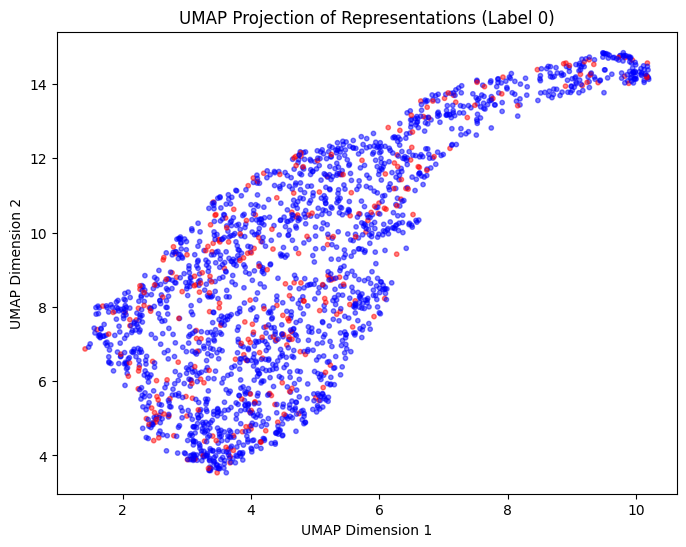

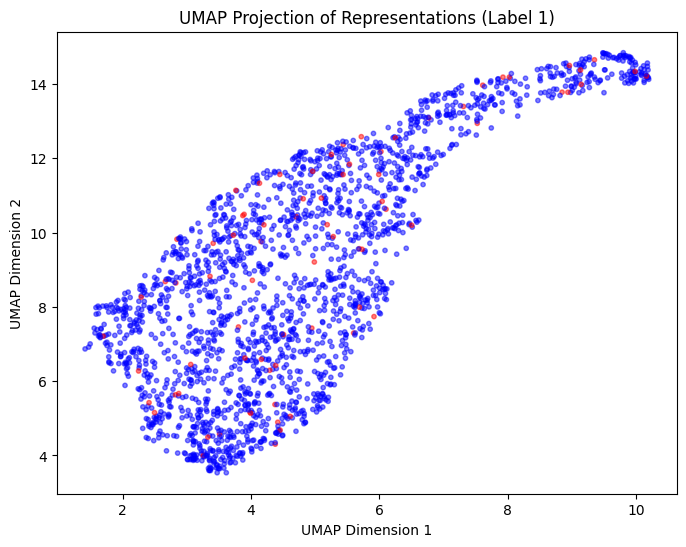

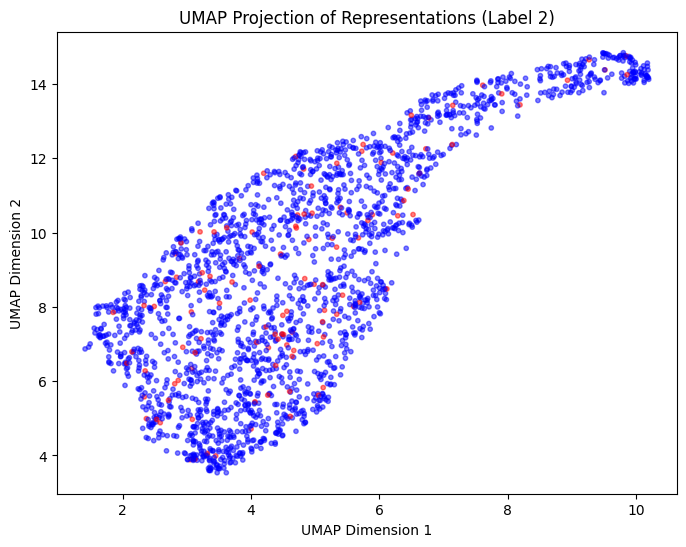

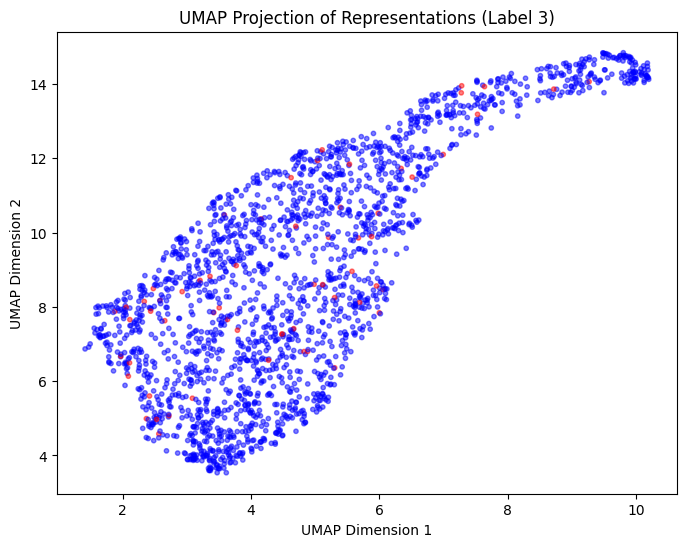

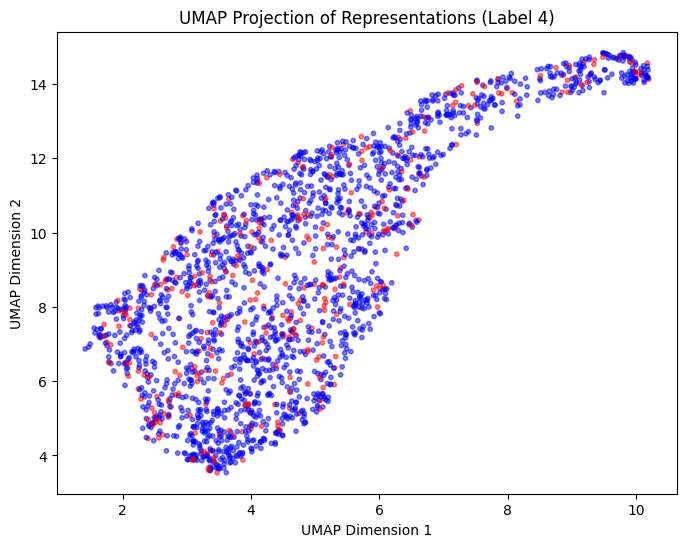

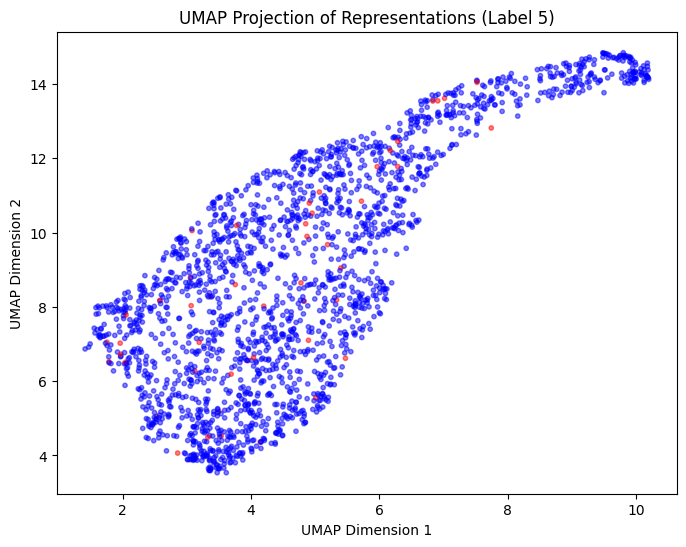

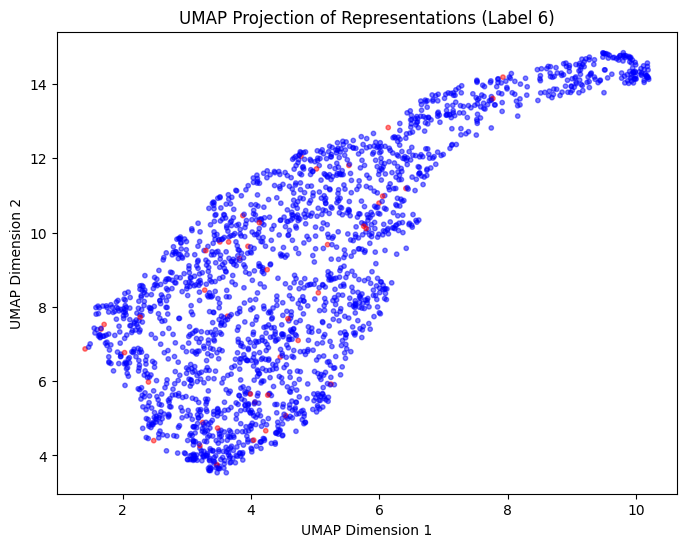

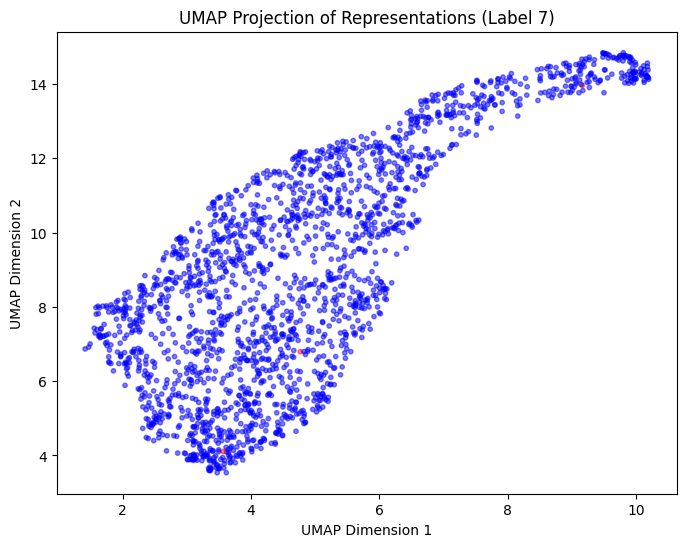

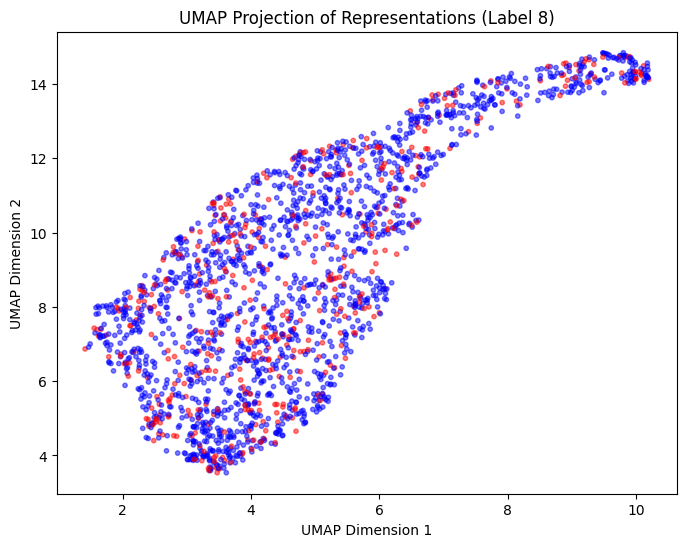

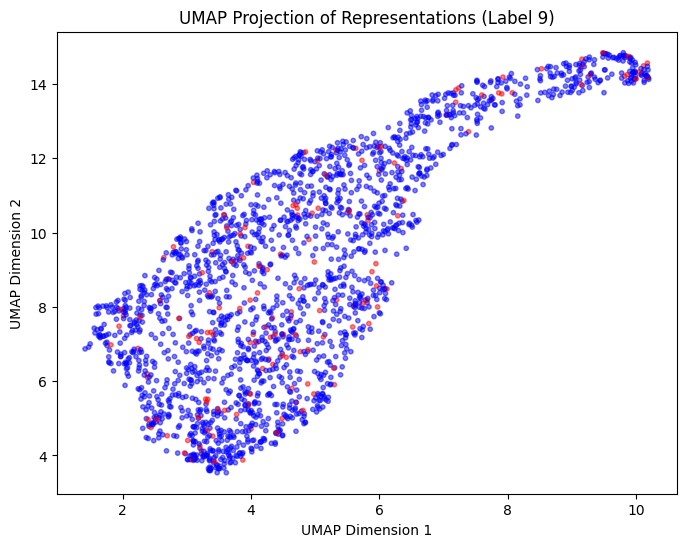

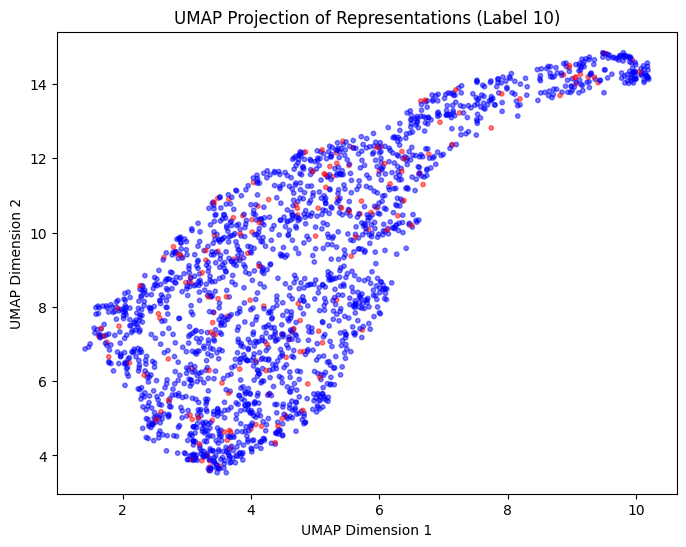

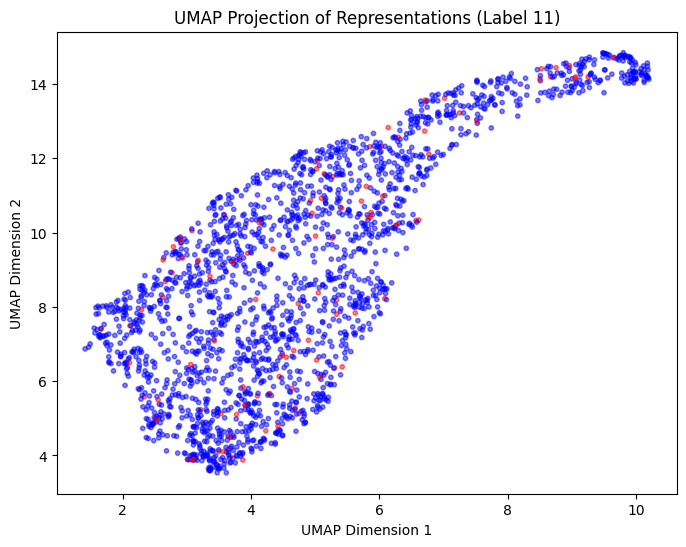

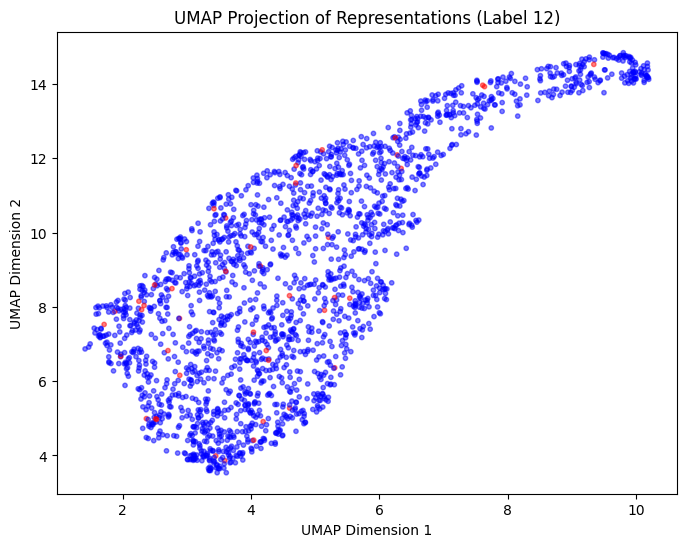

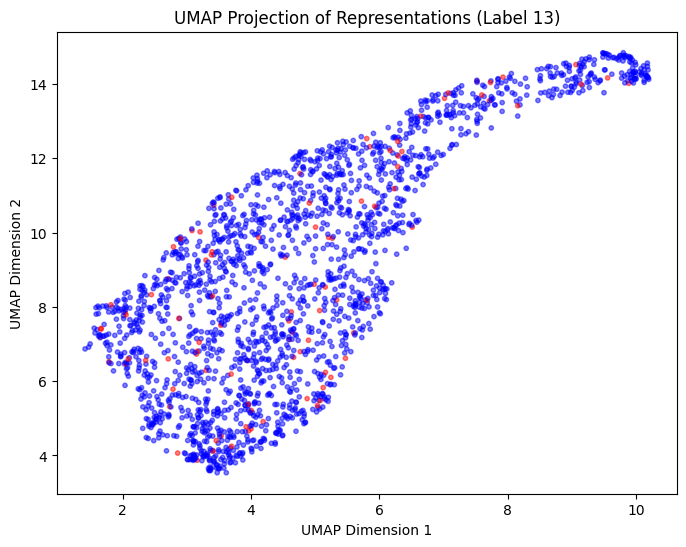

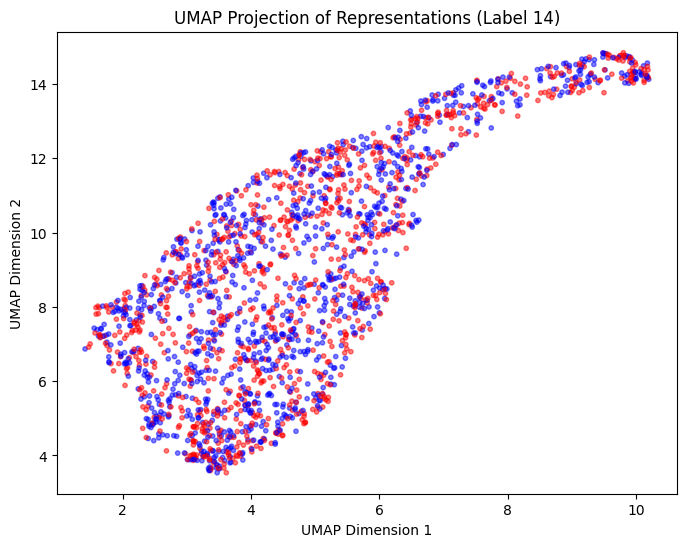

In [18]:
representations = torch.load(train_lab_representations_path)
targets = torch.load(train_lab_targets_path)

# Apply UMAP to reduce dimensions to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
representations_2d = umap_model.fit_transform(representations)

# Plot the 2D representations
for i in range(targets.shape[1]):
    plt.figure(figsize=(8, 6))
    colors = ['red' if label == 1 else 'blue' for label in targets[:, i].numpy()]
    plt.scatter(representations_2d[:, 0], representations_2d[:, 1], c=colors, alpha=0.5, s=10)
    plt.title(f"UMAP Projection of Representations (Label {i})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()